# **IMPORTADO DE MÓDULOS**

In [1]:
import numpy as np

import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from keras.regularizers import l2
import keras.backend as K

import tensorflow as tf
tf.version.VERSION

2024-04-29 13:56:04.648920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 13:56:04.674431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 13:56:05.067384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [2]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [3]:
V55= np.load('/home/josea/Co60_5cm_5cm.npy')
V28= np.load('/home/josea/Co60_2cm_8cm.npy')
V82= np.load('/home/josea/Co60_8cm_2cm.npy')

# **PREPROCESSING AND FUNCTIONS**

In [4]:
start_cfd = 50
stop_cfd = 80

#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start_cfd:stop_cfd,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


In [5]:
def find_fraction_index(vector, fraction=0.1):
  new_vector = np.copy(vector)
  energy = np.sum(new_vector, axis = 1)
  cumulative = np.cumsum(new_vector, axis = 1)
  for i in range(new_vector.shape[0]):
    indices = np.where(cumulative[i,:] >= energy[i]*fraction)[0]
    index = indices[0]
    new_vector[i,index:] = 0
  return new_vector


#-----------------------------------------------------------------------------------------------------------

def constant_fraction_discrimination(vector, fraction = 0.1):
    fraction_part = np.zeros_like(vector)
    shifted_fraction_part = np.zeros_like(vector)
    corrected_signal = np.zeros_like(vector)
    for i in range(vector.shape[0]):
      fraction_part[i,:] = vector[i,:] - fraction
      shift  = -np.argmax(fraction_part[i,:])
      shifted_fraction_part[i,:] = np.roll(fraction_part[i,:], shift)
      shifted_fraction_part[i,:shift] =  0 #fraction_part[i,shift:]
      corrected_signal[i,:] = vector[i,:] + shifted_fraction_part[i,:]
      plt.plot(corrected_signal[i,:])
    return corrected_signal

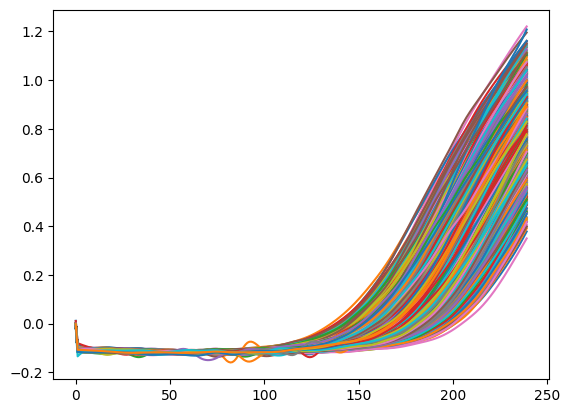

In [6]:
#new_V28_dec0 = find_fraction_index(new_V28[:,:,0])
#new_V55_dec0 = find_fraction_index(new_V55[:,:,0])
#new_V82_dec0 = find_fraction_index(new_V82[:,:,0])

#new_V28_dec1 = find_fraction_index(new_V28[:,:,1])
#new_V55_dec1 = find_fraction_index(new_V55[:,:,1])
#new_V82_dec1 = find_fraction_index(new_V82[:,:,1])


new_V28_dec0 = constant_fraction_discrimination(new_V28[:,:,0])
new_V55_dec0 = constant_fraction_discrimination(new_V55[:,:,0])
new_V82_dec0 = constant_fraction_discrimination(new_V82[:,:,0])

new_V28_dec1 = constant_fraction_discrimination(new_V28[:,:,1])
new_V55_dec1 = constant_fraction_discrimination(new_V55[:,:,1])
new_V82_dec1 = constant_fraction_discrimination(new_V82[:,:,1])

V28_fraction = np.concatenate((new_V28_dec0[:,:,np.newaxis],new_V28_dec1[:,:,np.newaxis]), axis = 2)
V55_fraction = np.concatenate((new_V55_dec0[:,:,np.newaxis],new_V55_dec1[:,:,np.newaxis]), axis = 2)
V82_fraction = np.concatenate((new_V82_dec0[:,:,np.newaxis],new_V82_dec1[:,:,np.newaxis]), axis = 2)

In [7]:
def momentos(vector):
  Nev,Nt,Nc = np.shape(vector)    #Nev: Núm eventos, Nt: Núm puntos temporales, Nc: Número canales
  t = np.reshape(np.linspace(0,Nt, Nt)/float(Nt),(1,-1,1))#Normalized array of time
  MOMENT = np.zeros((Nev,0,Nc))

  for i in range(4): #Number of moments used

    W = t**(i+1)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis= 1)

    W = np.exp(-(i*t))
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis= 1)

    W = np.exp(-(t**(i)))
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)


  return MOMENT

In [8]:
INPUT = np.concatenate((V55_fraction,V28_fraction,V82_fraction),axis= 0)
Ncasos = INPUT.shape[0]

# **DETECTOR 0**

In [9]:
INPUT2_dec0 = np.zeros_like(INPUT)
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec0[i,:,0] = np.roll(INPUT[i,:,0],N0)
  INPUT2_dec0[i,:,0] = INPUT2_dec0[i,:,0] + smoothed_noise
  INPUT2_dec0[i,0:N0,0] =  INPUT[i,0:N0,0] + smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec0[i,:,1 ]= np.roll(INPUT[i,:,0],N1)
  INPUT2_dec0[i,:,1] = INPUT2_dec0[i,:,1] + smoothed_noise
  INPUT2_dec0[i,0:N1,1] = INPUT[i,0:N1,0] + smoothed_noise[0:N1]

  REF_dec0[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)


trainX_dec0 = INPUT2_dec0[:,:,:]
REF_train_dec0 = REF_dec0[:]

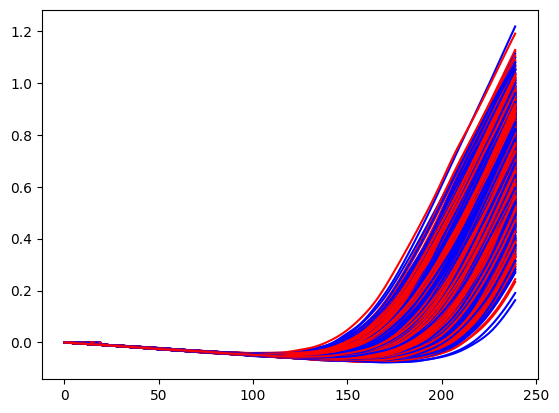

In [10]:
t = np.arange(Nt_new) / float(Nt_new)
for i in range(trainX_dec0.shape[0]):
  plt.plot(t*trainX_dec0[i,:,0],'b-')
  plt.plot(t*trainX_dec0[i,:,1],'r-')

In [11]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)

(736, 12, 2) NM = 12


# **DETECTOR 1**

In [12]:
INPUT2_dec1 = np.zeros_like(INPUT)
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise00 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec1[i,:,0]=np.roll(INPUT[i,:,1],N0)
  INPUT2_dec1[i,:,0] = INPUT2_dec1[i,:,0] + smoothed_noise
  INPUT2_dec1[i,0:N0,0] = INPUT[i,0:N0,0] + smoothed_noise[0:N0]

  N1 = NRD1[i]
  noise11 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec1[i,:,1]=np.roll(INPUT[i,:,1],N1)
  INPUT2_dec1[i,:,1] = INPUT2_dec1[i,:,1] + smoothed_noise
  INPUT2_dec1[i,0:N1,1] = INPUT[i,0:N1,0] + smoothed_noise[0:N1]

  REF_dec1[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)


trainX_dec1 = INPUT2_dec1[:,:,:]
REF_train_dec1 = REF_dec1[:]

In [13]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]

print(M_Train_dec1.shape, "NM =", NM)

(736, 12, 2) NM = 12


# **FULL TOF**

In [14]:
REFERENCE_PULSE_dec0 = np.tile(V82_fraction[0,:,0], (V82_fraction.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(V82_fraction[0,:,1], (V82_fraction.shape[0],2,1)).swapaxes(1,2)


M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

M_V28 = momentos(V28_fraction)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(V55_fraction)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(V82_fraction)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)

(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


In [15]:
def weights_definition(NM, Npoints):
  t = np.linspace(0,Npoints, Npoints)/float(Npoints) #Normalized array of time
  Weights = np.zeros((Npoints,NM))
  NMW = int(NM/3) #Number of Moments per weight

  for i in range(NMW):
    Weights[:,i] = t**(i+1)

  for i in range(NMW):
    Weights[:,i + NMW] = np.exp(-t**(i))

  for i in range(NMW):
    Weights[:,i + 2*(NMW)] = np.exp(-(i)*t)

  return Weights

#--------------------------------------------------------------------------------------------------
NM = 12
weights = weights_definition(NM,70)

In [16]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x2 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x3 = Dense(128, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1) , kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

#---------------------------------------------------------------------------------------------------------------------------------------------

def model_definition_manual_weight_initialization(N_time_points):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  #x1 = Dense(NM, activation="relu", weights=[weights, np.zeros(NM)])
  x1 = Dense(NM, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x4 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x5 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [ ]:
Ntries= 10

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(Ntries):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs=250, batch_size = 64, shuffle = True, verbose=0)
  history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs=250, batch_size = 64, shuffle = True, verbose=0)

  #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0, epochs=250, batch_size = 64, shuffle = True, verbose=0)
  #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1, epochs=250, batch_size = 64, shuffle = True, verbose=0)

  TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
  TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
  TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
  TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])
  TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
  TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])

  #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:V82_fraction.shape[0],:,0],V82_fraction[:,:,0]])
  #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:V82_fraction.shape[0],:,0],V82_fraction[:,:,1]])
  #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:V55_fraction.shape[0],:,0],V55_fraction[:,:,0]])
  #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:V55_fraction.shape[0],:,0],V55_fraction[:,:,1]])
  #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:V28_fraction.shape[0],:,0],V28_fraction[:,:,0]])
  #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:V28_fraction.shape[0],:,0],V28_fraction[:,:,1]])

  TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
  TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
  TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


In [ ]:
for i in range(TOFN_V28_array.shape[0]):
  centroid_V28 = -1*np.mean(TOFN_V28_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  centroid_V82 = -1*np.mean(TOFN_V82_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82-0.2)) / 2
  mean_std = (np.std(TOFN_V82_array[i,:]) + np.std(TOFN_V55_array[i,:]) + np.std(TOFN_V28_array[i,:])) / 3

  epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
  print('index: %d  %.3f %.3f %.3f' % (i, mean_std, mean_error_centroid,epsilon))

index: 0  0.084 0.010 0.085
index: 1  0.092 0.035 0.098
index: 2  0.081 0.013 0.082
index: 3  0.084 0.023 0.087
index: 4  0.096 0.039 0.104
index: 5  0.096 0.025 0.099
index: 6  0.085 0.024 0.088
index: 7  0.092 0.175 0.198
index: 8  0.088 0.030 0.093
index: 9  0.072 0.007 0.073


In [17]:
epochs = 1500
num_semillas = 1

epsilon = []
bias = []
std = []
training_loss_dec0 = []
training_loss_dec1 = []

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(num_semillas):
  #tf.random.set_seed(seed_value)

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=5e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=5e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  squared_sum = []
  MEC = []
  MSTD = []
  loss_dec0 = []
  loss_dec1 = []
  TOFN_V28_epoch = []
  TOFN_V55_epoch = []
  TOFN_V82_epoch = []

  for epoch in range(epochs):
     history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0, epochs=1, batch_size = 64, shuffle = True, verbose=1)
     history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1, epochs=1, batch_size = 64, shuffle = True, verbose=1)
     
     loss_dec0.append(history_dec0.history['loss'])
     loss_dec1.append(history_dec1.history['loss'])

     #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0, epochs=1, batch_size = 64, shuffle = True, verbose=1)
     #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1, epochs=1, batch_size = 64, shuffle = True, verbose=1)
     
     TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
     TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])
     TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
     TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
     TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
     TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])

     #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V82_norm.shape[0],:,0],new_V82[:,:,0]])
     #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V82_norm.shape[0],:,0],new_V82[:,:,1]])
     #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V55_norm.shape[0],:,0],new_V55[:,:,0]])
     #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V55_norm.shape[0],:,0],new_V55[:,:,1]])
     #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:M_V28_norm.shape[0],:,0],new_V28[:,:,0]])
     #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:M_V28_norm.shape[0],:,0],new_V28[:,:,1]])


     TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28
     TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
     TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
    
     TOFN_V28_epoch.append(TOFN_V28)
     TOFN_V55_epoch.append(TOFN_V55)
     TOFN_V82_epoch.append(TOFN_V82)


     centroid_V28 = -1*np.mean(TOFN_V28) + np.mean(TOFN_V55)
     centroid_V82 = -1*np.mean(TOFN_V82) + np.mean(TOFN_V55)
     mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82 - 0.2)) / 2
     mean_std = (np.std(TOFN_V82) + np.std(TOFN_V55) + np.std(TOFN_V28)) / 3
     
     squared_sum.append(np.sqrt(mean_error_centroid**2 + mean_std**2))
     MEC.append(mean_error_centroid)
     MSTD.append(mean_std)

     #model_dec0.save(directory + 'model_dec0_' + str(i) + '.h5')
     #model_dec1.save(directory + 'model_dec1_' + str(i) + '.h5')

  training_loss_dec0.append(loss_dec0)
  training_loss_dec1.append(loss_dec1)
  epsilon.append(squared_sum)
  bias.append(MEC)
  std.append(MSTD)

  TOFN_V28_list.append(TOFN_V28_epoch)
  TOFN_V55_list.append(TOFN_V55_epoch)
  TOFN_V82_list.append(TOFN_V82_epoch)

  tf.keras.backend.clear_session()

epsilon = np.array(epsilon, dtype = 'object')
bias = np.array(bias, dtype='object')
std = np.array(std, dtype='object')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'object')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'object')

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')

2024-04-29 13:56:19.574542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 13:56:19.596287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 13:56:19.596376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

 1/12 ━━━━━━━━━━━━━━━━━━━━ 8s 794ms/step - loss: 422.0719

I0000 00:00:1714391780.691409 1042291 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 386.4809
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 388.4653
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 344.1049
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 346.5622
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 339.0411
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 338.2333
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
6

(array([0]), array([1360])) 0.08595772323166646


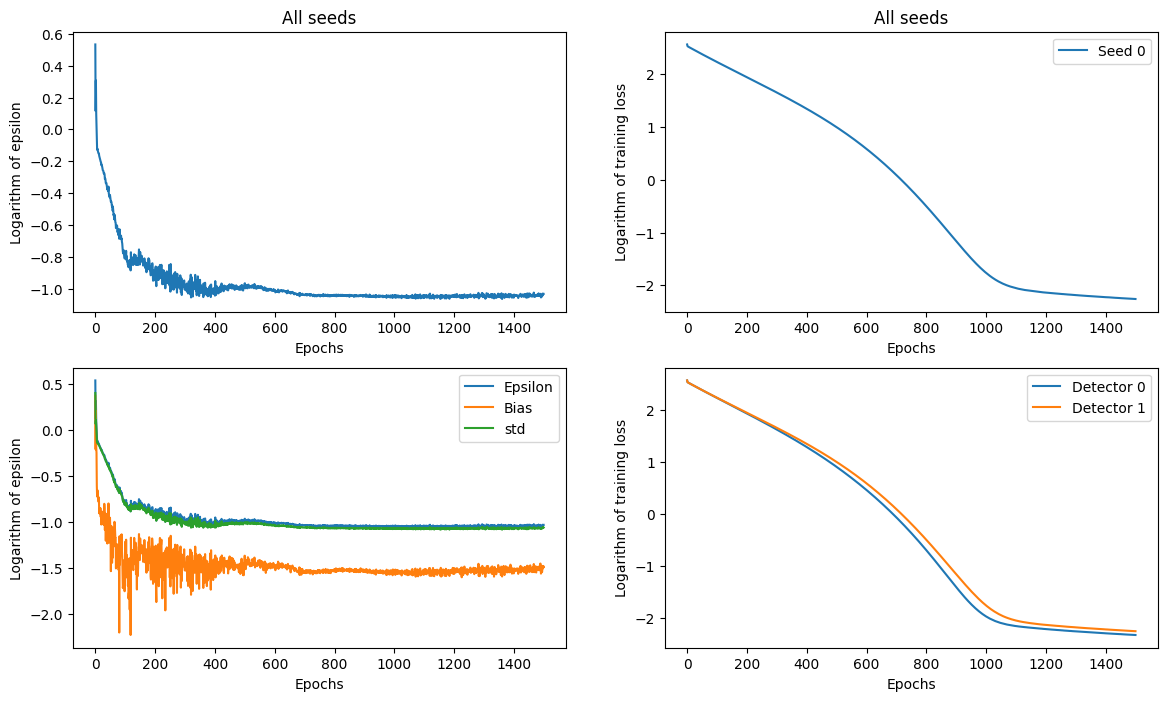

In [18]:
epsilon = np.array(epsilon, dtype='float64')
bias = np.array(bias, dtype='float64')
std = np.array(std, dtype = 'float64')

training_loss_dec0 = np.array(training_loss_dec0, dtype = 'float64')
training_loss_dec1 = np.array(training_loss_dec1, dtype = 'float64')


print(np.where(epsilon == np.min(epsilon)), np.min(epsilon))
index = 0
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
for i in range(epsilon.shape[0]):
  plt.plot(np.log10(epsilon[i,:]))
  #plt.plot(np.log10(std[i,:]))
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')
plt.title('All seeds')

plt.subplot(2,2,2)
for i in range(training_loss_dec0.shape[0]):
  label = 'Seed' + ' ' + str(i)
  #plt.plot(np.log10(training_loss_dec0[i,:]),label=label)
  plt.plot(np.log10(training_loss_dec1[i,:]),label=label)
plt.legend()
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')
plt.title('All seeds')


plt.subplot(2,2,3)
plt.plot(np.log10(epsilon[index,:]), label = 'Epsilon')
plt.plot(np.log10(bias[index,:]), label = 'Bias')
plt.plot(np.log10(std[index,:]), label = 'std')
plt.legend()
plt.ylabel('Logarithm of epsilon')
plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(np.log10(training_loss_dec0[index,:]),label='Detector 0')
plt.plot(np.log10(training_loss_dec1[index,:]),label='Detector 1')
plt.ylabel('Logarithm of training loss')
plt.xlabel('Epochs')

plt.legend()


V82: CENTROID(ns) = 0.214  FWHM(ns) = 0.204  std(ns) = 0.087
V55: CENTROID(ns) = 0.009  FWHM(ns) = 0.180  std(ns) = 0.077
V28: CENTROID(ns) = -0.227  FWHM(ns) = 0.202  std(ns) = 0.086


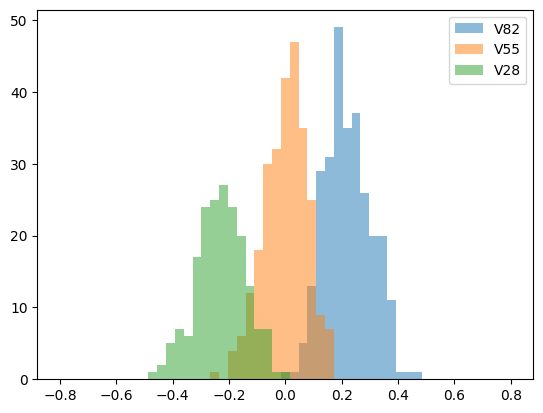

In [21]:
epoch = 1360
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index,epoch,:]) + np.mean(TOFN_V55_array[index,epoch,:]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

# **ENSEMBLE MODEL**

In [ ]:
#--------------------------- Get the mean results from all tries/seeds --------------------------
mean_V28 = np.squeeze(np.mean(TOFN_V28_array, axis=0))[epoch,:]
mean_V55 = np.squeeze(np.mean(TOFN_V55_array, axis=0))[epoch,:]
mean_V82 = np.squeeze(np.mean(TOFN_V82_array, axis=0))[epoch,:]


#---------------------------- Get the weighted mean by the accuracy of their bias result ------------------------------------------
weighted_mean_V28 = np.average(np.squeeze(TOFN_V28_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V55 = np.average(np.squeeze(TOFN_V55_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)
weighted_mean_V82 = np.average(np.squeeze(TOFN_V82_array[:,epoch,:]), weights=(1/bias[:,epoch]), axis=0)

Simple mean:
V82: CENTROID(ns) = 0.216  FWHM(ns) = 0.239  std(ns) = 0.102
V55: CENTROID(ns) = 0.008  FWHM(ns) = 0.208  std(ns) = 0.088
V28: CENTROID(ns) = -0.241  FWHM(ns) = 0.217  std(ns) = 0.092

Weighted mean:
V82: CENTROID(ns) = 0.215  FWHM(ns) = 0.239  std(ns) = 0.102
V55: CENTROID(ns) = 0.009  FWHM(ns) = 0.207  std(ns) = 0.088
V28: CENTROID(ns) = -0.240  FWHM(ns) = 0.218  std(ns) = 0.093


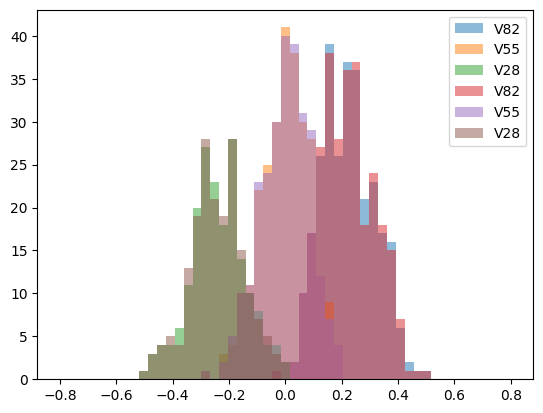

In [20]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(mean_V82) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(mean_V55) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(mean_V28) + np.mean(mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('Simple mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(weighted_mean_V82) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(weighted_mean_V55) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(weighted_mean_V28) + np.mean(weighted_mean_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28

print('')
print('Weighted mean:')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))